<a href="https://colab.research.google.com/github/Jumas-Cola/Neural_Networks_and_CV/blob/master/PyTorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [17]:
import sklearn.datasets
wine = sklearn.datasets.load_wine()
wine.data.shape

(178, 13)

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    wine.data[:, :2],
    wine.target,
    test_size=0.3,
    shuffle=True
)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [0]:
class WineNet(torch.nn.Module):
  def __init__(self, n_hidden_neurons):
    super().__init__()
    self.fc1 = torch.nn.Linear(2, n_hidden_neurons)
    self.act1 = torch.nn.Tanh()
    # self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
    # self.act2 = torch.nn.Sigmoid()
    self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
    self.sm = torch.nn.Softmax(dim=1)
  
  def forward(self, x):
    x = self.fc1(x)
    x = self.act1(x)
    # x = self.fc2(x)
    # x = self.act2(x)
    x = self.fc3(x)
    return x
  
  def interference(self, x):
    x = self.forward(x)
    x = self.sm(x)
    return x

wine_net = WineNet(20)

In [0]:
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(wine_net.parameters(), lr=1.0e-4)

In [21]:
np.random.permutation(5)

array([2, 0, 1, 4, 3])

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


tensor(0.2407) Epoch:  0
tensor(0.2407) Epoch:  0
tensor(0.5370) Epoch:  100
tensor(0.4630) Epoch:  200
tensor(0.4630) Epoch:  300
tensor(0.4630) Epoch:  400
tensor(0.4630) Epoch:  500
tensor(0.4815) Epoch:  600
tensor(0.4815) Epoch:  700
tensor(0.4815) Epoch:  800
tensor(0.4815) Epoch:  900
tensor(0.4630) Epoch:  1000
tensor(0.4630) Epoch:  1100
tensor(0.4630) Epoch:  1200
tensor(0.5185) Epoch:  1300
tensor(0.5185) Epoch:  1400
tensor(0.5926) Epoch:  1500
tensor(0.6111) Epoch:  1600
tensor(0.5741) Epoch:  1700
tensor(0.6111) Epoch:  1800
tensor(0.7222) Epoch:  1900
tensor(0.7593) Epoch:  2000
tensor(0.7593) Epoch:  2100
tensor(0.7593) Epoch:  2200
tensor(0.7593) Epoch:  2300
tensor(0.7593) Epoch:  2400
tensor(0.7593) Epoch:  2500
tensor(0.7593) Epoch:  2600
tensor(0.7593) Epoch:  2700
tensor(0.7593) Epoch:  2800
tensor(0.7593) Epoch:  2900
tensor(0.7963) Epoch:  3000
tensor(0.7593) Epoch:  3100
tensor(0.7593) Epoch:  3200
tensor(0.7593) Epoch:  3300
tensor(0.7593) Epoch:  3400
tensor(

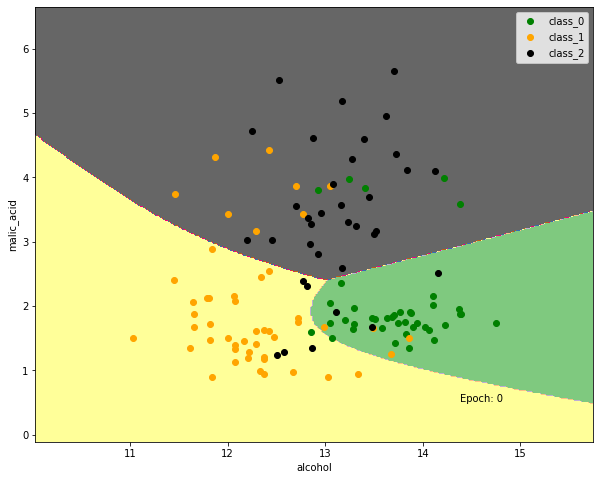

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation

batch_size = 100

plt.rcParams['figure.figsize'] = (10, 8)

n_classes = 3
plot_colors = ['g', 'orange', 'black']
plot_step = 0.02

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = torch.meshgrid(torch.arange(x_min, x_max, plot_step),
                          torch.arange(y_min, y_max, plot_step))

fig, ax = plt.subplots()

def animate(frame):
  epoches_per_frame = 10
  ################################### Train <epoches_per_frame> epoches
  for epoch in range(epoches_per_frame):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
      optimizer.zero_grad()

      batch_indexes = order[start_index:start_index+batch_size]

      x_batch = X_train[batch_indexes]
      y_batch = y_train[batch_indexes]

      preds = wine_net.forward(x_batch)

      loss_val = loss(preds, y_batch)
      loss_val.backward()

      optimizer.step()
    
    if (epoches_per_frame * frame + epoch) % 100 == 0:
      test_preds = wine_net.forward(X_test)
      test_preds = test_preds.argmax(dim=1)
      print((test_preds == y_test).float().mean(),
            'Epoch: ', epoches_per_frame * frame + epoch)

  ################################### Plotting current frame
  plt.cla() # clear plot field
  preds = wine_net.interference(torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1))
  preds_class = preds.data.numpy().argmax(axis=1)
  preds_class = preds_class.reshape(xx.shape)
  plt.contourf(xx, yy, preds_class, cmap='Accent')

  for i, color in zip(range(n_classes), plot_colors):
    indexes = np.where(y_train == i)
    plt.scatter(X_train[indexes, 0],
                X_train[indexes, 1],
                c=color,
                label=wine.target_names[i],
                cmap='Accent')
    plt.xlabel(wine.feature_names[0])
    plt.ylabel(wine.feature_names[1])
    plt.legend()
  plt.text(0.8, 0.1, 'Epoch: {}'.format(epoches_per_frame * frame),
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes)


ani = animation.FuncAnimation(fig, animate, interval=100, frames=1000)
ani.save('train.gif', writer='imagemagick')
